In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
#%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
def get_ERA5(era_pl, era_srfc, indic):
    
    dic = {}

    dic['q_col'] = []
    dic['u_col'] = []
    dic['r_col'] = []
    dic['v_col'] = []
    ### single values
    dic['tcwv'] = []
    dic['CAPE'] = []
    dic['dates'] = []
    dic['tmin'] = []
    dic['tmean'] = []
    dic['t10'] = []
    dic['area'] = []
    dic['area70'] = []
    dic['lat'] = []
    dic['lon'] = []
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    
    for id, date in enumerate(indic.date):
        
        print('Doing', date)
        

#         getera_pl =np.where((era_pl['time.day']==(indic['date'])[id].day) & (era_pl['time.month']==indic.month[id]) 
#                             & (era_pl['time.year']==indic.year[id]) & (era_pl['time.hour']==12))
        
#         getera_sf =np.where((era_srfc['time.day']==(indic['date'])[id].day)  & (era_srfc['time.year']==indic.year[id]) 
#                             & (era_srfc['time.month']==indic.month[id]) & (era_srfc['time.hour']==12))

        time = str(date.year)+str(date.month).zfill(2)+str(date.day).zfill(2)+'T12'

        try:
            era_day_pl = era_pl.sel(time=time).isel(time=0)
        except (TypeError, IndexError):
            print('Era missing:', date)
            for k in dic.keys():
                dic[k].append(np.nan)
            continue

        era_day_sf = era_srfc.sel(time=time).isel(time=0)

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['dates'].append(date)
        dic['lat'].append(elat)
        dic['lon'].append(elon)
        
        point = era_day_sf.sel(latitude=elat, longitude=elon, method='nearest')
        
        posx = int(np.where(era_day_sf.longitude == point.longitude)[0])
        posy = int(np.where(era_day_sf.latitude == point.latitude)[0])

        dic['u925'].append(np.asscalar((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel(level=925).mean().values)))
        dic['u650'].append(np.asscalar((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=650).mean().values)))
        dic['q925'].append(np.asscalar((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=925).mean().values)))
        dic['q700'].append(np.asscalar((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=700).mean().values)))
        dic['CAPE'].append(np.asscalar((era_day_sf['cape'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean().values)))
        dic['tcwv'].append(np.asscalar((era_day_sf['tcwv'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean().values)))
                          
        dic['q_col'].append((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['u_col'].append((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['r_col'].append((era_day_pl['r'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['v_col'].append((era_day_pl['v'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        
        dic['tmin'].append(indic.tmin[id])
        dic['tmean'].append(indic.tmean[id])
        dic['t10'].append(indic.t10[id])
        dic['area'].append(indic.area[id])
        dic['area70'].append((indic['70area'])[id])
    dic['level'] = era_pl.level.values
    
    return dic

In [ ]:
def get_ERA5_clim(era_pl_mean, era_srfc_mean, indic):
    
    dic = {}

    dic['q_col'] = []
    dic['u_col'] = []
    dic['r_col'] = []
    dic['v_col'] = []
    ### single values
    dic['tcwv'] = []
    dic['CAPE'] = []
    dic['dates'] = []
    dic['tmin'] = []
    dic['tmean'] = []
    dic['t10'] = []
    dic['area'] = []
    dic['area70'] = []
    dic['lat'] = []
    dic['lon'] = []
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    
    for id, date in enumerate(indic.date):
        
        print('Doing', date)
        

#         getera_pl =np.where((era_pl['time.day']==(indic['date'])[id].day) & (era_pl['time.month']==indic.month[id]) 
#                             & (era_pl['time.year']==indic.year[id]) & (era_pl['time.hour']==12))
        
#         getera_sf =np.where((era_srfc['time.day']==(indic['date'])[id].day)  & (era_srfc['time.year']==indic.year[id]) 
#                             & (era_srfc['time.month']==indic.month[id]) & (era_srfc['time.hour']==12))

        time = str(date.year)+'-'+(date.month).zfill(2)+str(date.day).zfill(2)+'T12'

        try:
            era_day_pl = era_pl.sel(time=time).isel(time=0)
        except (TypeError, IndexError):
            print('Era missing:', date)
            for k in dic.keys():
                dic[k].append(np.nan)
            continue

        era_day_sf = era_srfc.sel(time=time).isel(time=0)

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['dates'].append(date)
        dic['lat'].append(elat)
        dic['lon'].append(elon)
        
        point = era_day_sf.sel(latitude=elat, longitude=elon, method='nearest')
        
        posx = int(np.where(era_day_sf.longitude == point.longitude)[0])
        posy = int(np.where(era_day_sf.latitude == point.latitude)[0])

        dic['u925'].append(np.asscalar((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel(level=925).mean().values)))
        dic['u650'].append(np.asscalar((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=650).mean().values)))
        dic['q925'].append(np.asscalar((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=925).mean().values)))
        dic['q700'].append(np.asscalar((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).sel( level=700).mean().values)))
        dic['CAPE'].append(np.asscalar((era_day_sf['cape'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean().values)))
        dic['tcwv'].append(np.asscalar((era_day_sf['tcwv'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean().values)))
                          
        dic['q_col'].append((era_day_pl['q'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['u_col'].append((era_day_pl['u'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['r_col'].append((era_day_pl['r'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        dic['v_col'].append((era_day_pl['v'].isel(latitude=slice(posy-3,posy+3), longitude=slice(posx-3,posx+3)).mean(['latitude', 'longitude']).values))
        
        dic['tmin'].append(indic.tmin[id])
        dic['tmean'].append(indic.tmean[id])
        dic['t10'].append(indic.t10[id])
        dic['area'].append(indic.area[id])
        dic['area70'].append((indic['70area'])[id])
    dic['level'] = era_pl.level.values
    
    return dic

In [5]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [6]:
pdf_march = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 3) & (pdf.year >=2000))
pdf_march = pdf_march.dropna()

In [7]:
pdf_oct = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 10) & (pdf.year >=2000))
pdf_oct = pdf_oct.dropna()

In [33]:
era_pl = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/pressure_levels/*.nc')
era_srfc = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/surface/*.nc')

In [48]:
era_pl['ymonth'] = ('time', [str(y)+'-'+str(m)+'-'+str(h) for (y,m,h) in zip(era_pl['time.year'].values,era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_mean =  era_pl.groupby(grouped).mean(dim='time')

In [51]:
era_srfc['ymonth'] = ('time', [str(y)+'-'+str(m)+'-'+str(h) for (y,m,h) in zip(era_srfc['time.year'].values,era_srfc['time.month'].values,era_srfc['time.hour'].values)])
grouped='ymonth'
era_srfc_mean =  era_srfc.groupby(grouped).mean(dim='time')

In [47]:
era_pl_mean

<xarray.Dataset>
Dimensions:    (latitude: 73, level: 19, longitude: 133, ymonth: 149)
Coordinates:
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 4.75 4.5 4.25 4.0
  * level      (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
  * ymonth     (ymonth) object '2000-1' '2000-10' ... '2012-4' '2012-5'
Data variables:
    pv         (ymonth, level, latitude, longitude) float32 dask.array<shape=(149, 19, 73, 133), chunksize=(1, 19, 73, 133)>
    t          (ymonth, level, latitude, longitude) float32 dask.array<shape=(149, 19, 73, 133), chunksize=(1, 19, 73, 133)>
    q          (ymonth, level, latitude, longitude) float32 dask.array<shape=(149, 19, 73, 133), chunksize=(1, 19, 73, 133)>
    w          (ymonth, level, latitude, longitude) float32 dask.array<shape=(149, 19, 73, 133), chunksize=(1, 19, 73, 133)>
    d          (ymonth, level, latitude, longitude) float32 dask.array<s

In [9]:
era_pl_box = era_pl.sel(latitude=slice(7.5,4.5), longitude=slice(-12,12))

In [52]:
q_clim_march = era_pl_box['q'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==3)].mean(['latitude', 'longitude','time'])
u_clim_march = era_pl_box['u'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==3)].mean(['latitude', 'longitude','time'])
v_clim_march = era_pl_box['v'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==3)].mean(['latitude', 'longitude','time'])

In [53]:
q_clim_oct = era_pl_box['q'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==10)].mean(['latitude', 'longitude','time'])
u_clim_oct = era_pl_box['u'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==10)].mean(['latitude', 'longitude','time'])
v_clim_oct = era_pl_box['v'][(era_pl_box['time.hour']==12)&(era_pl_box['time.month']==10)].mean(['latitude', 'longitude','time'])

In [12]:
q_clim_oct.values

array([5.69420990e-05, 1.83720607e-04, 3.95964831e-04, 7.16251554e-04,
       1.18527003e-03, 1.93428551e-03, 3.03512090e-03, 4.22707573e-03,
       5.09281689e-03, 5.88065572e-03, 7.07634445e-03, 8.71986430e-03,
       1.17519861e-02, 1.27799865e-02, 1.37435822e-02, 1.45613989e-02,
       1.52245937e-02, 1.58360358e-02, 1.65317673e-02], dtype=float32)

In [13]:
# era_out = get_ERA5(era_pl, era_srfc, pdf_march)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'wb'))

In [14]:
era_march = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'rb'))
era_oct = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct.p', 'rb'))

In [15]:
level = era_march.pop('level')
level = era_oct.pop('level')

In [16]:
for k in era_march.keys():
    era_march[k] = era_march[k][0:1841]

In [17]:
for k in era_oct.keys():
    era_oct[k] = era_oct[k][0:2096]

In [18]:
np.array(era_oct['CAPE']).mean()

1063.4757279858334

In [19]:
np.array(era_march['CAPE']).mean()

1237.0779014713798

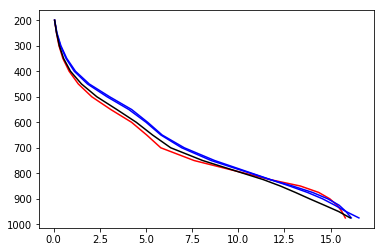

In [20]:
q_march = np.array(era_march['q_col']).mean(axis=0)
q_oct = np.array(era_oct['q_col']).mean(axis=0)
plt.plot(q_march*1000, era_pl.level.values,'r')
plt.plot(q_oct*1000,era_pl.level.values, 'b')
plt.plot(q_clim_oct*1000,era_pl.level.values, 'b-')
plt.plot(q_clim_march*1000,era_pl.level.values, 'k-')
plt.gca().invert_yaxis()

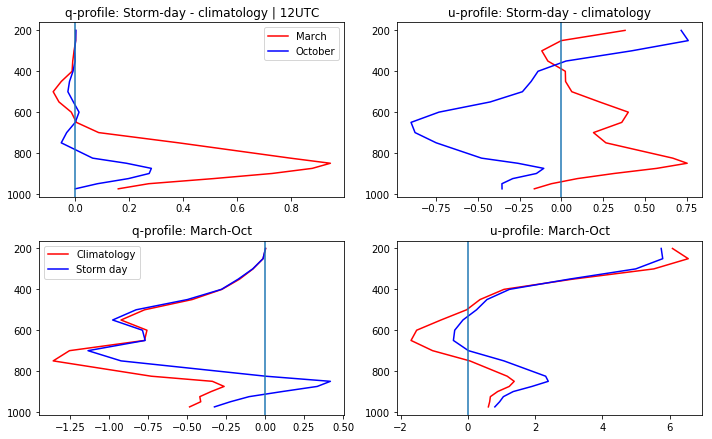

In [54]:
q_march = np.array(era_march['q_col']).mean(axis=0)*1000 - q_clim_march*1000 
q_oct = np.array(era_oct['q_col']).mean(axis=0)*1000 - q_clim_oct*1000 
f = plt.figure(figsize=(10,9))
f.add_subplot(321)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Storm-day - climatology | 12UTC')
plt.legend()

q_march = np.array(era_march['u_col']).mean(axis=0) - u_clim_march
q_oct = np.array(era_oct['u_col']).mean(axis=0) - u_clim_oct
f.add_subplot(322)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Storm-day - climatology')


q_march = q_clim_march*1000 - q_clim_oct*1000
q_oct = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(era_oct['q_col']).mean(axis=0)*1000
f.add_subplot(323)
plt.plot(q_march, era_pl.level.values,'r', label='Climatology')
plt.plot(q_oct, era_pl.level.values,'b', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = u_clim_march - u_clim_oct
q_oct = np.array(era_march['u_col']).mean(axis=0) - np.array(era_oct['u_col']).mean(axis=0)
f.add_subplot(324)
plt.plot(q_march, era_pl.level.values,'r', label='Climatology')
plt.plot(q_oct, era_pl.level.values,'b', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

plt.tight_layout()

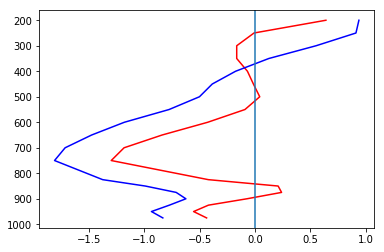

In [22]:
q_march = np.array(era_march['u_col']).mean(axis=0) - u_clim_march 
q_oct = np.array(era_oct['u_col']).mean(axis=0) - u_clim_oct 
plt.plot(q_march, era_pl.level.values,'r')
plt.plot(q_oct, era_pl.level.values,'b')
plt.axvline(x=0)
plt.gca().invert_yaxis()

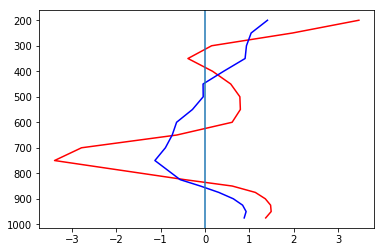

In [23]:
q_march = np.array(era_march['v_col']).mean(axis=0)- q_clim_march
q_oct = np.array(era_oct['v_col']).mean(axis=0)- q_clim_oct
plt.plot(q_march, era_pl.level.values,'r')
plt.plot(q_oct, era_pl.level.values,'b')
plt.axvline(x=0)
plt.gca().invert_yaxis()

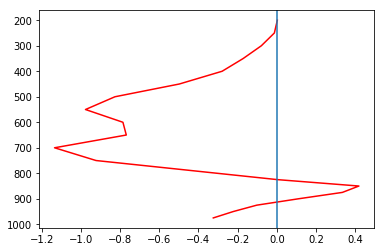

In [24]:
q_march = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(era_oct['q_col']).mean(axis=0)*1000
plt.plot(q_march, era_pl.level.values,'r')
plt.axvline(x=0)
plt.gca().invert_yaxis()

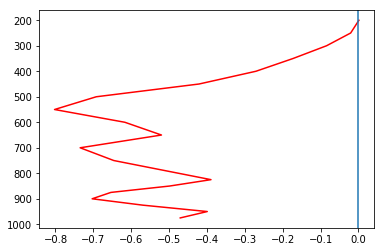

In [25]:
q_march = q_clim_march*1000 - q_clim_oct*1000
plt.plot(q_march, era_pl.level.values,'r')
plt.axvline(x=0)
plt.gca().invert_yaxis()

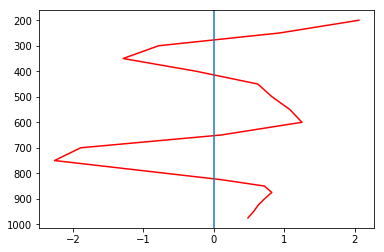

In [238]:
q_march = np.array(era_march['v_col']).mean(axis=0) - np.array(era_oct['v_col']).mean(axis=0)
plt.plot(q_march, era_pl.level.values,'r')
plt.axvline(x=0)
plt.gca().invert_yaxis()

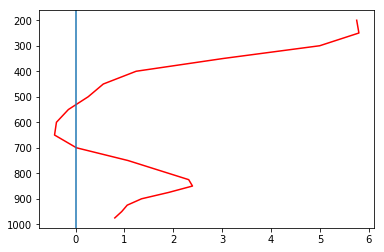

In [239]:
q_march = np.array(era_march['u_col']).mean(axis=0) - np.array(era_oct['u_col']).mean(axis=0)
plt.plot(q_march, era_pl.level.values,'r')
plt.axvline(x=0)
plt.gca().invert_yaxis()

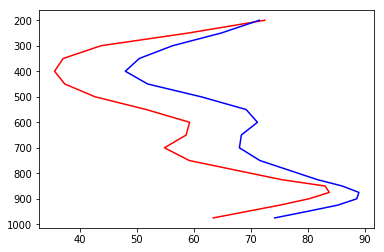

In [226]:
q_march = np.array(era_march['r_col']).mean(axis=0)
q_oct = np.array(era_oct['r_col']).mean(axis=0)
plt.plot(q_march, era_pl.level.values,'r')
plt.plot(q_oct,era_pl.level.values, 'b')
plt.gca().invert_yaxis()

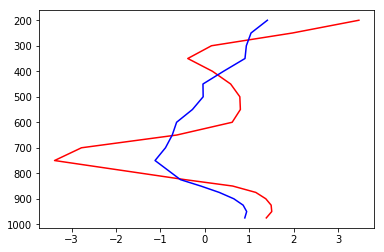

In [227]:
q_march = np.array(era_march['v_col']).mean(axis=0)
q_oct = np.array(era_oct['v_col']).mean(axis=0)
plt.plot(q_march, era_pl.level.values,'r')
plt.plot(q_oct,era_pl.level.values, 'b')
plt.gca().invert_yaxis()

In [16]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])

In [17]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : month,
    'area' : area*7.7**2,
    'area70' : area70*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [18]:
ds = ds.dropna()

In [31]:
pos1 = ((ds.month>=9) | (ds.month<=5))  & (ds.u650<0) & (ds.area>=5000) # all storms, without trmm overpass - matchup via storm centre points
opos1 =((obs.month>=9) | (obs.month<=5)) & (obs.u650<0) & (obs.area>=5000) # storms with trmm overpass - matchup via cutout kernels
cpos1 = ((cp4.month>=9) | (cp4.month<=5))  & (cp4.u650<0) & (cp4.area>=5000) & (cp4.prcp>=0)  #cp4
cpos125 = ((cp25.month>=9) | (cp25.month<=5))  & (cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>=0) # p25

In [32]:
np.sum(cpos1)

19211

In [33]:
oposi = (obs.u650<0) & (obs.area>=5000) & (obs.prcp>=1) & ((obs.month>=9) | (obs.month<=5))
cposi4 = (cp4.u650<0) & (cp4.area>=5000) & (cp4.prcp>=1) & ((cp4.month>=9) | (cp4.month<=5))
cposi25 =(cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>=0.1) & ((cp25.month>=9) | (cp25.month<=5))

In [34]:
ds_march = ds[pos1]
obs_march = obs[opos1]
cp4_march = cp4[cpos1]
cp25_march = cp25[cpos125]

In [35]:
obsp = obs[oposi]
cp4p = cp4[cposi4]
cp25p = cp25[cposi25]

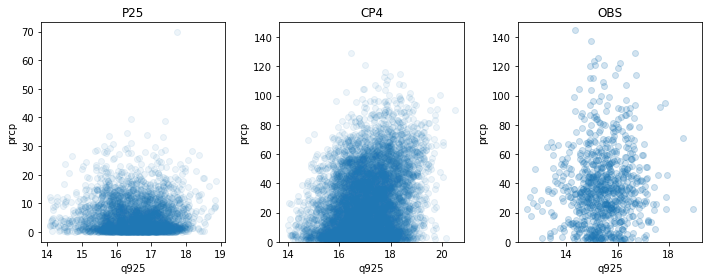

In [27]:
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(131)
plt.xlabel('q925')
plt.ylabel('prcp')
plt.title('P25')
isq = cp25p.q925>14
isqq = cp4p.q925>14
plt.scatter(cp25p.where(isq).q925, cp25p.where(isq).prcp, alpha=0.08)

ax = f.add_subplot(132)
plt.scatter(cp4p.where(isqq).q925, cp4p.where(isqq).prcp, alpha=0.08)
plt.xlabel('q925')
plt.title('CP4')
plt.ylabel('prcp')
ax.set_ylim(0,150)

ax = f.add_subplot(133)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

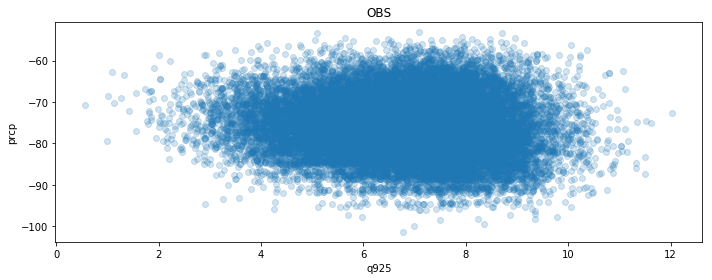

In [39]:
f = plt.figure(figsize=(10,4))
# ax = f.add_subplot(131)
# plt.xlabel('q925')
# plt.ylabel('prcp')
# plt.title('P25')
# isq = cp25p.q925>14
# isqq = cp4p.q925>14
# plt.scatter(cp25p.q925-cp25p.q700, cp25p.tmin, alpha=0.08)

# ax = f.add_subplot(132)
# plt.scatter(cp4p.q925-cp4p.q700, cp4p.tmin, alpha=0.08)
# plt.xlabel('q925')
# plt.title('CP4')
# plt.ylabel('prcp')
# ax.set_ylim(0,150)

ax = f.add_subplot(111)
plt.scatter(ds_march.q700, ds_march.tmin, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
#ax.set_ylim(0,150)
plt.tight_layout()

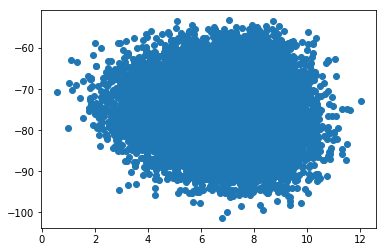

In [66]:
plt.scatter(ds_march.q700, ds_march.tmin)

In [35]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [67]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.u650, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.u650, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(223)

    data3, r3 = density_plot(dat.q925, dat.shear, dat.u650)

    mappable = ax2.scatter(dat.q925, dat.shear, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. qq/shear | umax removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data4, r4 = density_plot(dat.q700, dat.tmin, dat.u925)

    mappable = ax2.scatter(dat.q700, dat.tmin , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(0, 10)
    ax2.set_ylabel('min T')
    ax2.set_xlabel('qmid')
    ax2.set_title('P-corr. qq700/tmin | u650hPa removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [68]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

pears (0.255769170282489, 0.0)
pears (-0.18504189204529659, 4.803283502841906e-211)
pears (0.24272989324618527, 0.0)
pears (-0.08632142798275355, 8.595223896077429e-47)


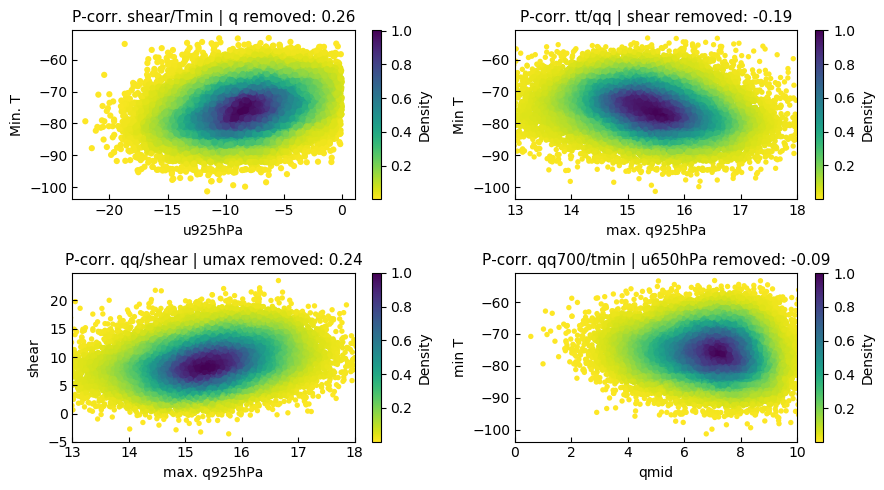

In [69]:
plot_scatter_month(ds_march)

In [39]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 5
p2 = 99

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=np.percentile(cp4_march.shear,p1)) & (cp4_march.shear<=np.percentile(cp4_march.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
shear25_march = np.percentile(cp25_march.shear[(cp25_march.shear>=np.percentile(cp25_march.shear,p1)) & (cp25_march.shear<=np.percentile(cp25_march.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))




abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, p1) , np.percentile(ds_march.q925, p2), nbq) 
qbinsc_march = np.linspace(np.percentile(cp4_march.q925, p1) , np.percentile(cp4_march.q925, p2), nbq)
qbinsc25_march = np.linspace(15 , np.percentile(cp25_march.q925, p2), nbq)

nbqq = 5
nbss = 5

p1 = 10
p2 = 90

shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,1)) & (obsp.shear<=np.percentile(obsp.shear,99))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))
shear_cp4p = np.percentile(cp4p.shear[(cp4p.shear>=np.percentile(cp4p.shear,p1)) & (cp4p.shear<=np.percentile(cp4p.shear,p2))], np.linspace(0,100,nbss)) #np.percentile(cp4p.shear[(cp4p.shear>=8) & (cp4p.shear<=20)], np.linspace(0,100,nbss))
shear_cp25p = np.percentile(cp25p.shear[(cp25p.shear>=np.percentile(cp25p.shear,p1)) & (cp25p.shear<=np.percentile(cp25p.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25p.shear[(cp25p.shear>=8) & (cp25p.shear<=20)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, 1) , np.percentile(obsp.q925, 99), nbqq)
qbinsc= np.linspace(np.percentile(cp4p.q925, p1) , np.percentile(cp4p.q925, p2), nbqq)
qbinsc25 = np.linspace(15, np.percentile(cp25p.q925, p2), nbqq)


In [40]:
shear_cp25p

array([ 9.03373322, 12.14674466, 14.16167801, 16.23155976, 19.25791367])

In [41]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmin[poss_ds], 10)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.percentile(ds.prcp[poss_ds], 75)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 75)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [42]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<50] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [43]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [46]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [47]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [48]:
cp4perc_mar, cp4pr_mar, cp4area_mar, cp4val_mar = create_2dhist(cp4_march, shearc_march, qbinsc_march)

In [49]:
cp25perc_mar, pc25pr_mar, cp25area_mar, cp25val_mar = create_2dhist(cp25_march, shear25_march, qbinsc25_march)

In [50]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)
cp4perc, pc4, cp4area, cp4val = create_2dhist(cp4p, shear_cp4p, qbinsc)
cp25perc, pc25, cp25area, cp25val = create_2dhist(cp25p, shear_cp25p, qbinsc25)

In [51]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

9.018628486485207
15.340541798957464


In [53]:
ds_mar_dic = {
    'data' : dsperc_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
    'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [54]:
cp4_mar_dic = {
    'data' : cp4perc_mar,
    'ybins' : qbinsc_march,
    'xbins' : shearc_march,
    'title' : 'CP4',
    'valid' : cp4val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],1),
    'vmax' : np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [55]:
cp25_mar_dic = {
    'data' : cp25perc_mar,
    'ybins' : qbinsc25_march,
    'xbins' : shear25_march,
    'title' : 'P25',
    'valid' : cp25val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(cp25perc_mar[(cp25perc_mar!=0) & np.isfinite(cp25perc_mar)],1),
    'vmax' : np.percentile(cp25perc_mar[(cp25perc_mar!=0) & np.isfinite(cp25perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [56]:
pcobs[pcobs==0]=np.nan
obsp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : '',
    'valid' : obsval,
    'cbarlabel' : '95th centile p',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
pc4[pc4==0]=np.nan
cp4_dic = {
    'data' : pc4,
    'ybins' : qbinsc,
    'xbins' : shear_cp4p,
    'title' : '',
    'valid' : cp4val,
    'cbarlabel' : '95th centile p',
    'vmin' : np.percentile(pc4[(pc4!=0) & np.isfinite(pc4)],1),
    'vmax' : np.percentile(pc4[(pc4!=0) & np.isfinite(pc4)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
pc25[pc25==0]=np.nan
cp25_dic = {
    'data' : pc25,
    'ybins' : qbinsc25,
    'xbins' : shear_cp25p,
    'title' : '',
    'valid' : cp25val,
    'cbarlabel' : '95th centile Max.p',
    'vmin' : np.percentile(pc25[(pc25!=0) & np.isfinite(pc25)],1),
    'vmax' : np.percentile(pc25[(pc25!=0) & np.isfinite(pc25)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

(array([1.000e+00, 2.000e+00, 1.400e+01, 3.600e+01, 1.330e+02, 2.930e+02,
        6.100e+02, 1.196e+03, 2.166e+03, 1.535e+03]),
 array([-65.99490949, -64.40726555, -62.8196216 , -61.23197766,
        -59.64433371, -58.05668977, -56.46904582, -54.88140187,
        -53.29375793, -51.70611398, -50.11847004]),
 <a list of 10 Patch objects>)

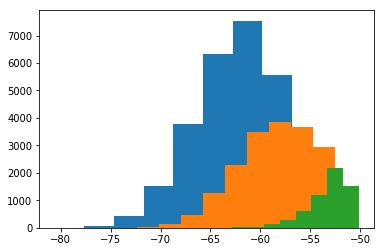

In [57]:
plt.hist(ds_march.tmean)
plt.hist(cp4_march.tmean)
plt.hist(cp25_march.tmean)

In [58]:
data_list = [ds_mar_dic, cp4_mar_dic, cp25_mar_dic,obsp_dic,cp4_dic,cp25_dic]

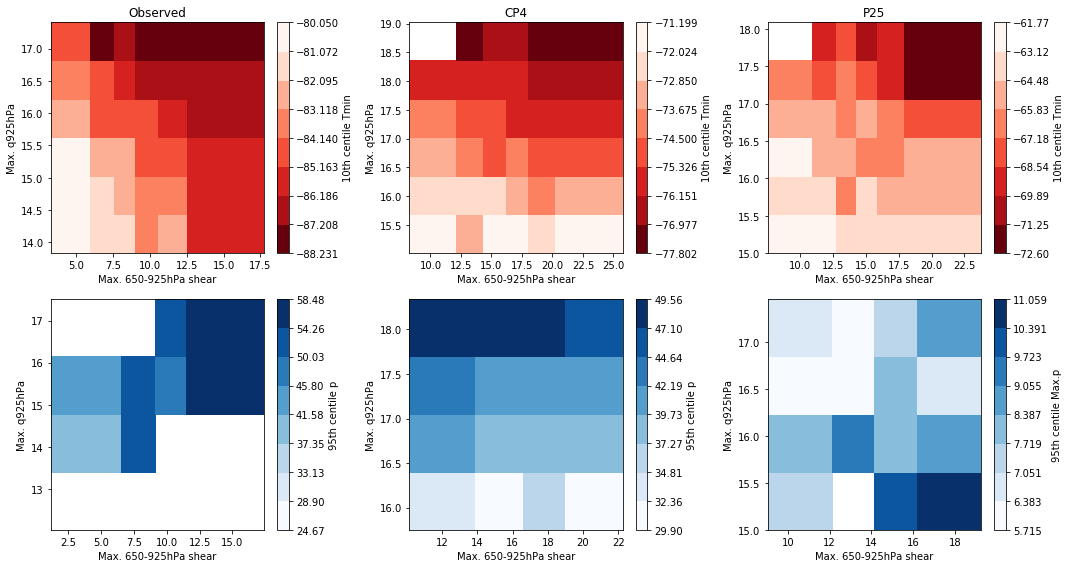

In [59]:
hist2d_six(data_list, valid=True)